In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
import numpy as np
from functools import partial

from tailoredcc.amplitudes import number_overlaps_tccsd

In [2]:
# def line(x, a, b):
#     return a + x * b

# def power_law_normal(x, a, b):
#     return a * np.power(x, b)

# def power_law_fit(x, y):
#     x_log = np.log10(x)
#     y_log = np.log10(y)
#     popt, pcov = curve_fit(line, x_log, y_log)
#     print("sigmas", np.sqrt(np.diagonal(pcov)))
#     a=np.power(10, popt[0])
#     b=popt[1]
#     fitted_power_law = partial(power_law_normal, a=a, b=b)
#     return a, b, fitted_power_law

In [2]:
# data = pd.read_hdf("noise_data_general_6mol.h5", key="df")
data = pd.read_hdf("noise_data_general_9mol.h5", key="df")

data_stretched = pd.read_hdf("noise_data_general_stretched.h5", key="df")
data = pd.concat([data, data_stretched], ignore_index=True)

print("Before NaN filter:", len(data.index))
data = data[data['df'].notna()]
print("After NaN filter:", len(data.index))

data['ncas'] = data.nact
data['nvirta'] = data.nact - data.nalpha
data['nvirtb'] = data.nact - data.nbeta
data['noverlaps'] = number_overlaps_tccsd(data.nact, data.nalpha, data.nbeta)
data['full_active_ratio'] =  data.noverlaps / number_overlaps_tccsd(data.nmo / 2, data.nelec // 2, data.nelec // 2)

Before NaN filter: 845
After NaN filter: 653


In [3]:
merged_df = pd.DataFrame()
payload = list(data.columns)
payload = [p for p in payload if p not in ['pytest_obj', 'test_id', 'status', 'duration_ms', 'df']]
for _, row in data.iterrows():
    inner_df = row['df']
    for p in payload:
        inner_df[p] = row[p]
    merged_df = pd.concat([merged_df, inner_df])
merged_df.reset_index(drop=True, inplace=True)

# merged_df = merged_df[merged_df['nact'] >= 4]
merged_df = merged_df[merged_df['noverlaps'] > 100]
# merged_df = merged_df[~merged_df.basis.str.contains('cc-pvdz')]

print(merged_df.shape)
print(merged_df.columns)
display(merged_df)
merged_df_backup = merged_df.copy()

(19590, 18)
Index(['std', 'e_tot', 'e_exact', 'tcc_error', 'basis', 'molname', 'nact',
       'nalpha', 'nbeta', 'nelec', 'nao', 'nmo', 'noverlaps_exp', 'ncas',
       'nvirta', 'nvirtb', 'noverlaps', 'full_active_ratio'],
      dtype='object')


std       e_tot     e_exact  tcc_error        basis    molname  nact   
0      0.001 -107.650188 -107.650214   0.000026       sto-3g         n2     6  \
1      0.001 -107.650717 -107.650214   0.000503       sto-3g         n2     6   
2      0.001 -107.650713 -107.650214   0.000500       sto-3g         n2     6   
3      0.001 -107.650807 -107.650214   0.000593       sto-3g         n2     6   
4      0.001 -107.650805 -107.650214   0.000592       sto-3g         n2     6   
...      ...         ...         ...        ...          ...        ...   ...   
19585  0.001 -230.226590 -230.226633   0.000043  aug-cc-pvdz  p-benzyne    16   
19586  0.001 -230.226520 -230.226633   0.000114  aug-cc-pvdz  p-benzyne    16   
19587  0.001 -230.226519 -230.226633   0.000114  aug-cc-pvdz  p-benzyne    16   
19588  0.001 -230.226771 -230.226633   0.000137  aug-cc-pvdz  p-benzyne    16   
19589  0.001 -230.226592 -230.226633   0.000041  aug-cc-pvdz  p-benzyne    16   

       nalpha  nbeta  nelec    nao    nmo  noverlaps_exp  ncas  nvirta   
0           3      3   14.0   10.0   20.0          118.0     6       3  \
1           3      3   14.0   10.0   20.0          118.0     6       3   
2           3      3   14.0   10.0   20.0          118.0     6       3   
3           3      3   14.0   10.0   20.0          118.0     6       3   
4           3      3   14.0   10.0   20.0          118.0     6       3   
...       ...    ...    ...    ...    ...            ...   ...     ...   
19585       8      8   40.0  174.0  348.0         5793.0    16       8   
19586       8      8   40.0  174.0  348.0         5793.0    16       8   
19587       8      8   40.0  174.0  348.0         5793.0    16       8   
19588       8      8   40.0  174.0  348.0         5793.0    16       8   
19589       8      8   40.0  174.0  348.0         5793.0    16       8   

       nvirtb  noverlaps  full_active_ratio  
0           3        118           0.193443  
1           3        118           0.193443  
2           3        118           0.193443  
3           3        118           0.193443  
4           3        118           0.193443  
...       ...        ...                ...  
19585       8       5793           0.000415  
19586       8       5793           0.000415  
19587       8       5793           0.000415  
19588       8       5793           0.000415  
19589       8       5793           0.000415  

[19590 rows x 18 columns]

### Create a dataframe with <E_TCC>

In [4]:
columns_to_groupby = ['std', 'basis', 'molname', 'nact', 'nalpha', 'nbeta', 'nelec', 'nao', 'nmo', 'noverlaps']
df_mean = merged_df.groupby(columns_to_groupby)['tcc_error'].mean().reset_index()
display(df_mean)

merged_df = df_mean

std   basis       molname  nact  nalpha  nbeta  nelec   nao   nmo   
0    0.001   6-31g  acetaldehyde     6       3      3   24.0  35.0  70.0  \
1    0.001   6-31g  acetaldehyde     8       2      2   24.0  35.0  70.0   
2    0.001   6-31g  acetaldehyde     8       3      3   24.0  35.0  70.0   
3    0.001   6-31g  acetaldehyde     8       4      4   24.0  35.0  70.0   
4    0.001   6-31g  acetaldehyde    10       5      5   24.0  35.0  70.0   
..     ...     ...           ...   ...     ...    ...    ...   ...   ...   
648  0.001  sto-3g     p-benzyne    16       3      3   40.0  34.0  68.0   
649  0.001  sto-3g     p-benzyne    16       4      4   40.0  34.0  68.0   
650  0.001  sto-3g     p-benzyne    16       5      5   40.0  34.0  68.0   
651  0.001  sto-3g     p-benzyne    16       6      6   40.0  34.0  68.0   
652  0.001  sto-3g     p-benzyne    16       8      8   40.0  34.0  68.0   

     noverlaps  tcc_error  
0          118   0.000078  
1          199   0.000093  
2          316   0.000084  
3          361   0.000096  
4          876   0.000153  
..         ...        ...  
648       2068   0.000344  
649       3193   0.000478  
650       4236   0.000492  
651       5071   0.000422  
652       5793   0.000645  

[653 rows x 11 columns]

In [5]:
def power_law_mol(X, b, c):
    noverlaps, nmo = X[:, 0], X[:, 1]
    return noverlaps**b * nmo**c

def power_law_mol_with_pref(X, a, b, c):
    noverlaps, nmo = X[:, 0], X[:, 1]
    return a * noverlaps**b * nmo**c

print(merged_df.shape)
grouped = merged_df.groupby("molname")

fit_data = []
for name, group in grouped:
    X = group[['noverlaps', 'nmo']].values
    y = group['tcc_error'].values
    popt, pcov = curve_fit(power_law_mol_with_pref, X, y)
    sigmas = np.sqrt(np.diagonal(pcov))
    a_fit, b_fit, c_fit = popt
    fit_data.append([name, a_fit, b_fit, c_fit, *sigmas])

# df_per_mol_fits = pd.DataFrame(data=fit_data, columns=["molname", "b", "c", "sigma_b", "sigma_c"])
df_per_mol_fits = pd.DataFrame(data=fit_data, columns=["molname", "a", "b", "c", "sigma_a", "sigma_b", "sigma_c"])
display(df_per_mol_fits)
del df_per_mol_fits

(653, 11)


molname         a         b         c   sigma_a   sigma_b   sigma_c
0    acetaldehyde  0.000469  0.337260 -0.809140  0.000143  0.034618  0.069364
1         benzene  0.001200  0.159305 -0.677414  0.000403  0.027331  0.055606
2             cl2  0.000561  0.529165 -1.191468  0.000417  0.046137  0.159969
3   cl2_stretched  0.000612  0.276063 -0.586004  0.000787  0.043835  0.306884
4              f2  0.001303  0.323093 -0.859824  0.000763  0.040510  0.136351
5    f2_stretched  0.001998  0.270797 -0.760639  0.000989  0.033188  0.116544
6    formaldehyde  0.000354  0.390938 -0.785068  0.000147  0.041475  0.092111
7           furan  0.001090  0.245337 -0.823972  0.000374  0.028792  0.058790
8             h2o  0.000611  0.574109 -1.216971  0.000426  0.074668  0.224538
9              n2  0.000393  0.348810 -0.668161  0.000230  0.044545  0.133598
10   n2_stretched  0.001971  0.133508 -0.217044  0.000683  0.024044  0.081530
11            nco  0.001699  0.269015 -0.926466  0.000615  0.032915  0.072350
12      p-benzyne  0.001393  0.165359 -0.576436  0.000330  0.019491  0.038976

In [6]:
import numpy as np
from scipy.optimize import curve_fit
X = merged_df[['noverlaps', 'nmo']].values
y = merged_df['tcc_error'].values
print(X.shape, y.shape)


def power_law(noverlaps, nmo, a, b, c):
    return a * np.power(noverlaps, b) * np.power(nmo, c)

def power_law_stacked(X, a, b, c):
    # noverlaps, nmo, nelec = X[:, 0], X[:, 1], X[:, 2]
    noverlaps, nmo = X[:, 0], X[:, 1]
    return a * np.power(noverlaps, b) * np.power(nmo, c) #* np.power(nelec, d)

def power_law_1d(X, a, b, c):
    # noverlaps, nmo, nelec = X[0], X[1], X[2]
    noverlaps, nmo = X[0], X[1]
    return a * np.power(noverlaps, b) * np.power(nmo, c) #* np.power(nelec, d)

# Perform the curve fitting
popt, pcov = curve_fit(power_law_stacked, X, y)
stderr = np.sqrt(np.diagonal(pcov))
print(stderr)

# Extract the fitted coefficients
a_fit, b_fit, c_fit = popt
d_fit = 0

# Print the fitted coefficients
print(f"Fitted coefficients: a={a_fit}, b={b_fit}, c={c_fit}, d={d_fit}")

merged_df['tcc_error_fit'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo], a_fit, b_fit, c_fit), axis=1)

# merged_df['tcc_error_fit_best'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo], a_fit + stderr[0], b_fit - stderr[1], c_fit - stderr[2]), axis=1)
# merged_df['tcc_error_fit_worst'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo], a_fit - stderr[0], b_fit + stderr[1], c_fit + stderr[2]), axis=1)

(653, 2) (653,)
[0.00237119 0.0381758  0.09950506]
Fitted coefficients: a=0.005593940828040118, b=0.2773936428653616, c=-1.0736602434908196, d=0


In [7]:
from tqdm import tqdm
boots_iter = 10_000

def run_powerlaw_fit(df=None):
    X = df[['noverlaps', 'nmo']].values
    y = df['tcc_error'].values
    popt, _ = curve_fit(power_law_stacked, X, y)
    return popt

boots_data = []
for N in tqdm(range(boots_iter)):
    sample_idx = np.random.randint(low=0, high=df_mean.shape[0], size=df_mean.shape[0])
    df_resampled = df_mean.iloc[sample_idx]
    assert sample_idx.size > np.unique(sample_idx).size
    assert df_mean.shape == df_resampled.shape
    popt = run_powerlaw_fit(df_resampled)
    boots_data.append(popt)
df_boots = pd.DataFrame(data=boots_data, columns=["a", "b", "c"])
stderr = df_boots.std().values


100%|██████████| 10000/10000 [01:02<00:00, 161.25it/s]


In [8]:
display(df_boots.describe())
print(df_boots.std().values)

a             b             c
count  10000.000000  10000.000000  10000.000000
mean       0.006886      0.278529     -1.085801
std        0.005063      0.054315      0.116235
min        0.001088      0.079191     -1.676534
25%        0.003950      0.241532     -1.157991
50%        0.005524      0.276459     -1.075298
75%        0.008090      0.314228     -1.003795
max        0.094314      0.510335     -0.743977

[0.00506292 0.05431471 0.11623502]


In [27]:
# keep the exponents b and c fixed and fit only the prefactor a per molecule
def power_law_mol_with_pref(X, a, b, c):
    noverlaps, nmo = X[:, 0], X[:, 1]
    return a * noverlaps**b * nmo**c

grouped = merged_df.groupby("molname")

power_law_only_pref = partial(power_law_mol_with_pref, b=b_fit, c=c_fit)
print(power_law_only_pref)
fit_data = []
for name, group in grouped:
    X = group[['noverlaps', 'nmo']].values
    y = group['tcc_error'].values
    popt, pcov = curve_fit(power_law_only_pref, X, y)
    sigmas = np.sqrt(np.diagonal(pcov))
    a_fit = popt[0]
    fit_data.append([name, a_fit, *sigmas])

df_per_mol_fits = pd.DataFrame(data=fit_data, columns=["molname", "a", "sigma_a"])
display(df_per_mol_fits)

prefactor_dict = {x.molname: x.a for _, x in df_per_mol_fits.iterrows()}
assert len(prefactor_dict) == df_per_mol_fits.shape[0]
merged_df['tcc_error_fit'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo], prefactor_dict[x.molname], b_fit, c_fit), axis=1)

merged_df['tcc_error_fit_best'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo],  prefactor_dict[x.molname], b_fit - stderr[1], c_fit - stderr[2]), axis=1)
merged_df['tcc_error_fit_worst'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo], prefactor_dict[x.molname], b_fit + stderr[1], c_fit + stderr[2]), axis=1)

functools.partial(<function power_law_mol_with_pref at 0x7f8c6f86cf70>, b=0.2773936428653616, c=-1.0736602434908196)


molname         a   sigma_a
0    acetaldehyde  0.002218  0.000088
1         benzene  0.002979  0.000127
2             cl2  0.002408  0.000118
3   cl2_stretched  0.004833  0.000300
4              f2  0.004270  0.000174
5    f2_stretched  0.006476  0.000235
6    formaldehyde  0.002598  0.000121
7           furan  0.002558  0.000087
8             h2o  0.003014  0.000225
9              n2  0.003203  0.000156
10   n2_stretched  0.018668  0.000997
11            nco  0.003002  0.000110
12      p-benzyne  0.005650  0.000232

<Axes: xlabel='molname'>

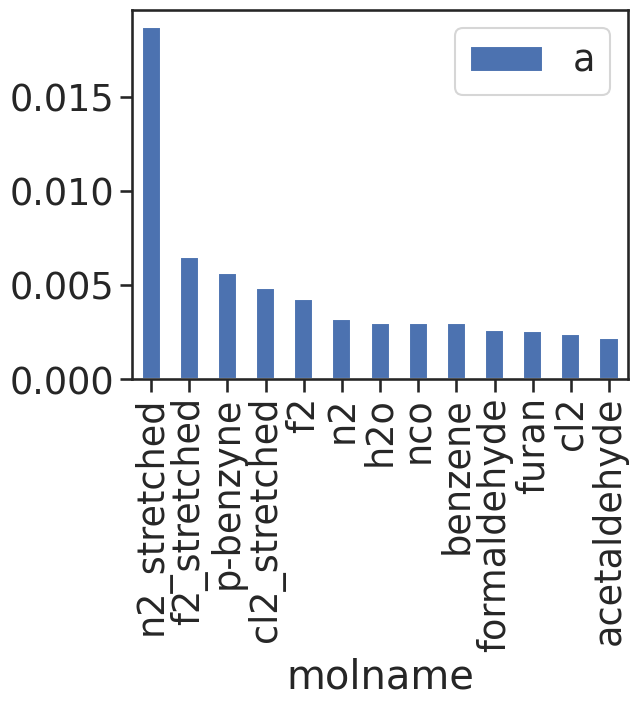

In [25]:
df_per_mol_fits.sort_values("a", inplace=True, ascending=False)
df_per_mol_fits.plot(x="molname", y="a", kind="bar")

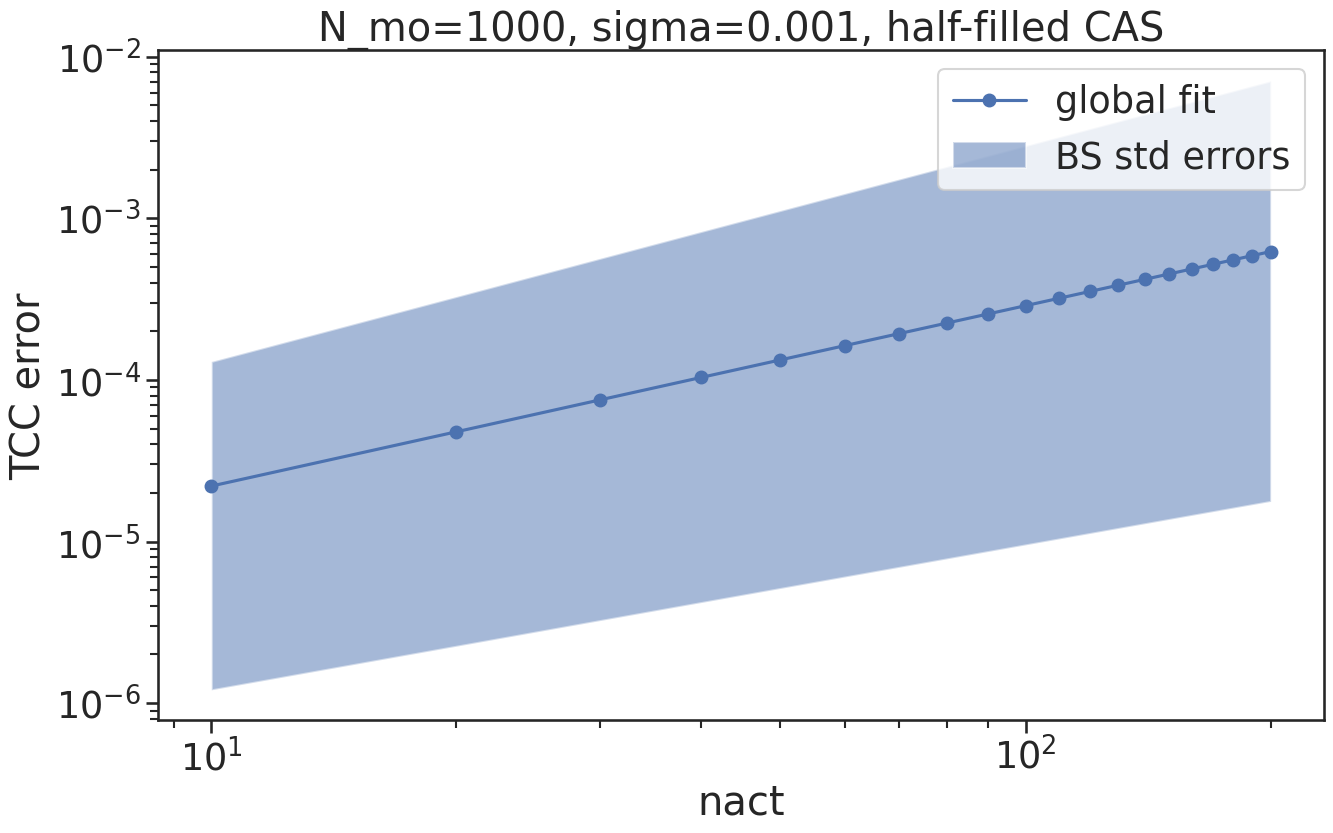

In [12]:
sigma = 1e-3
fitted_law = partial(power_law, a=a_fit, b=b_fit, c=c_fit)
fitted_law_best = partial(power_law, a=a_fit - stderr[0], b=b_fit - stderr[1], c=c_fit - stderr[2])
fitted_law_worst = partial(power_law, a=a_fit + stderr[0], b=b_fit + stderr[1], c=c_fit + stderr[2])
N_mo = 1000

nacts = np.arange(10, 210, 10)
nalphas = nacts // 2
nbetas = nacts // 2
overlaps = number_overlaps_tccsd(nacts, nalphas, nbetas)

y_best = fitted_law_best(overlaps, N_mo)
y_worst = fitted_law_worst(overlaps, N_mo)

sns.set_theme(context="talk", font_scale=1.6, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 9)
# ax.plot(nacts, y_best)
# ax.plot(nacts, y_worst)
ax.plot(nacts, fitted_law(overlaps, N_mo), "o-", label="global fit")
ax.fill_between(nacts, y_best, y_worst, alpha=0.5, label="BS std errors")
# sns.lineplot(x=nacts, y=y, ax=ax)
ax.set_ylabel("TCC error")
ax.set_xlabel("nact")
ax.set_title(f"N_mo={N_mo}, sigma={sigma}, half-filled CAS")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.tight_layout()


In [13]:
def bfit(n, zeta):
    return  0.8229825297733299 * n**0.6862683230378022 * zeta**-0.18216726780115386

def shot_budget(accuracy, nmo, nact, nalpha, nbeta, aexp, bexp, cexp):
    # compute noverlaps
    noverlaps = number_overlaps_tccsd(nact, nalpha, nbeta)
    
    assert nact == nalpha + nbeta
    bound = np.sqrt(nact)
    # bound = bfit(2 * nact, nalpha + nbeta)
    # print(bound, np.sqrt(2 * nact))

    # sigma = np.sqrt(sqrt(2) * b(2 * nact, nalpha + nbeta) / nshots)
    # a = sigma * a'
    # \Delta E = sigma * a' * noverlaps^b * nmo^c
    # \Delta E = np.sqrt(sqrt(2) * b(2 * nact, nalpha + nbeta) / nshots) * ...
    # \Delta E^2 = sqrt(2) * b / nshots * noverlaps^2b * nmo^2c
    # nshots = sqrt(2) * b / \Delta E^2 * noverlaps^2b * nmo^2c
    nshots = np.sqrt(2) * bound / accuracy**2 * noverlaps**(2*bexp) * nmo**(2*cexp) * aexp**2
    # print("=> Done", nshots)
    return nshots


sigma_fit = 1e-3
nmos = np.arange(400, 1000 + 1, 200)
nacts = list(range(10, 110, 10))
accuracy = 1e-3
budgets = []
for nmo in nmos:
    for nact in nacts:
        nalpha = nact // 2
        nbeta = nact // 2
        shots_global = shot_budget(accuracy, nmo, nact, nalpha, nbeta, a_fit / sigma_fit, b_fit, c_fit)
        shots_min = shot_budget(accuracy, nmo, nact, nalpha, nbeta, (a_fit - stderr[0]) / sigma_fit, b_fit - stderr[1], c_fit - stderr[2])
        shots_max = shot_budget(accuracy, nmo, nact, nalpha, nbeta, (a_fit + stderr[0]) / sigma_fit, b_fit + stderr[1], c_fit + stderr[2])
        budgets.append([accuracy, nmo, nact, nalpha, nbeta, shots_global, shots_min, shots_max])

df_shots = pd.DataFrame(data=budgets, columns=['accuracy', 'nmo', 'nact', 'nalpha', 'nbeta', 'shots_global', 'shots_min', 'shots_max'])
df_shots['nqubits'] = 2 * df_shots.nact

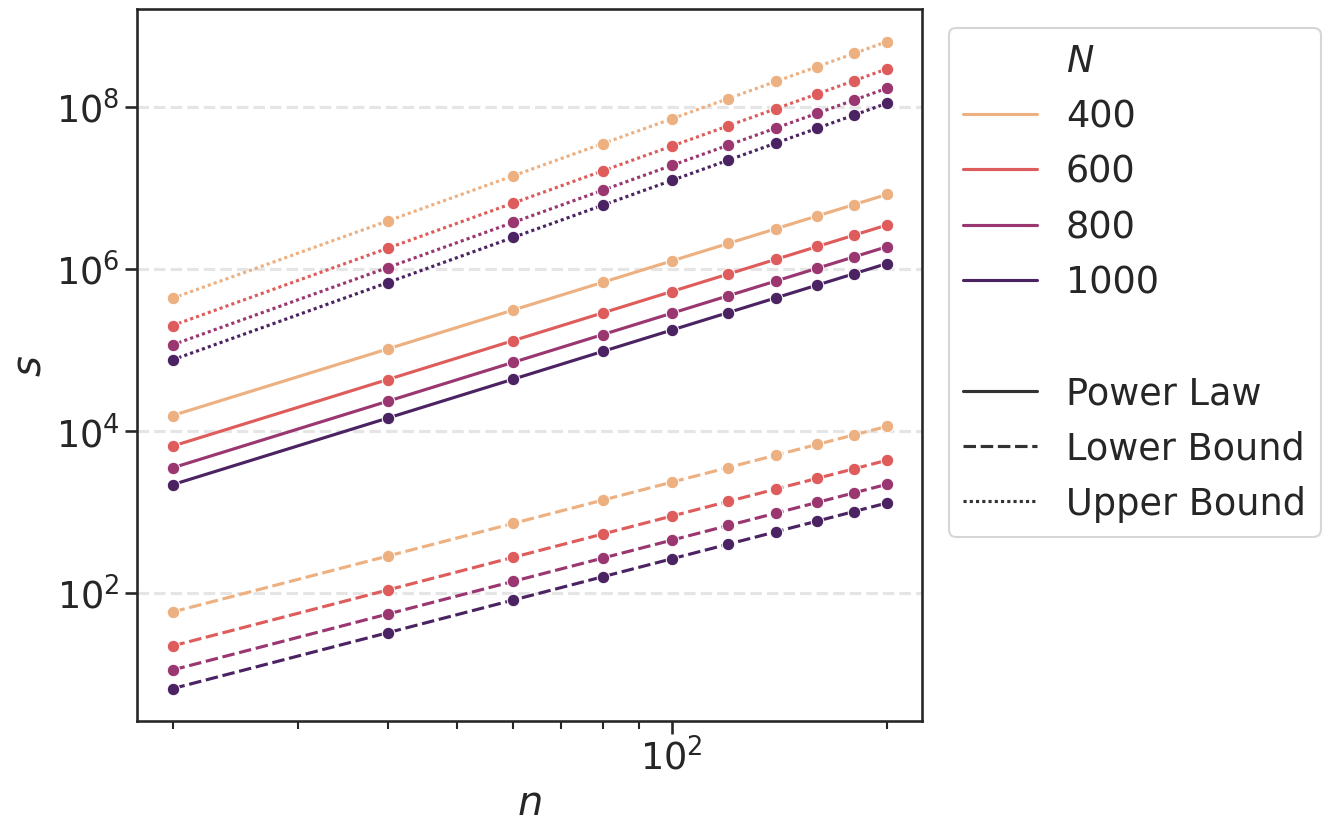

In [14]:
sns.set_theme(context="talk", font_scale=1.6, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 9)

dfm_shots = pd.melt(
    df_shots, value_name="shotbudget", var_name="estimation",
    value_vars=[
        "shots_global",
        "shots_min",
        "shots_max"
    ],
    id_vars=["nmo", "nqubits"])

for hline in [1e2, 1e4, 1e6, 1e8]:
    ax.axhline(hline, color="gray", linestyle="--", alpha=0.2)
# sns.lineplot(data=df_shots, x="nqubits", y="shots_global", hue="nmo", ax=ax, marker="o", palette="flare")
sns.lineplot(data=dfm_shots, x="nqubits", y="shotbudget", style="estimation", hue="nmo", ax=ax, marker="o", palette="flare")

# for i, (name, group) in enumerate(df_shots.groupby("nmo")):
#     x = group["nqubits"]
#     # y = group["shotbudget"]
#     # err = group["abs_mag_dens_sem"]
#     color = ax.get_lines()[i].get_c()
    
#     lower = group["shots_min"]
#     upper = group["shots_max"]
#     ax.fill_between(x, lower, upper, alpha=0.1, color=color)


ax.set_yscale("log")
ax.set_xscale("log")

# ax.set_xtick_labels(np.unique(df_shots.nqubits))
# ax.set_title(rf"half-filled CAS, $\Delta E={accuracy}$")

# ax.set_ylabel("# shots")
ax.set_ylabel(r"$s$")
ax.set_xlabel(r"$n$")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
changes = {
    "nmo": r"$N$",
    "estimation": "",
    "shots_global": "Power Law",
    "shots_min": "Lower Bound",
    "shots_max": "Upper Bound",
}
for tx in ax.get_legend().texts:
    for k, c in changes.items():
        if tx.get_text() == k:
            tx.set_text(c)
plt.tight_layout()


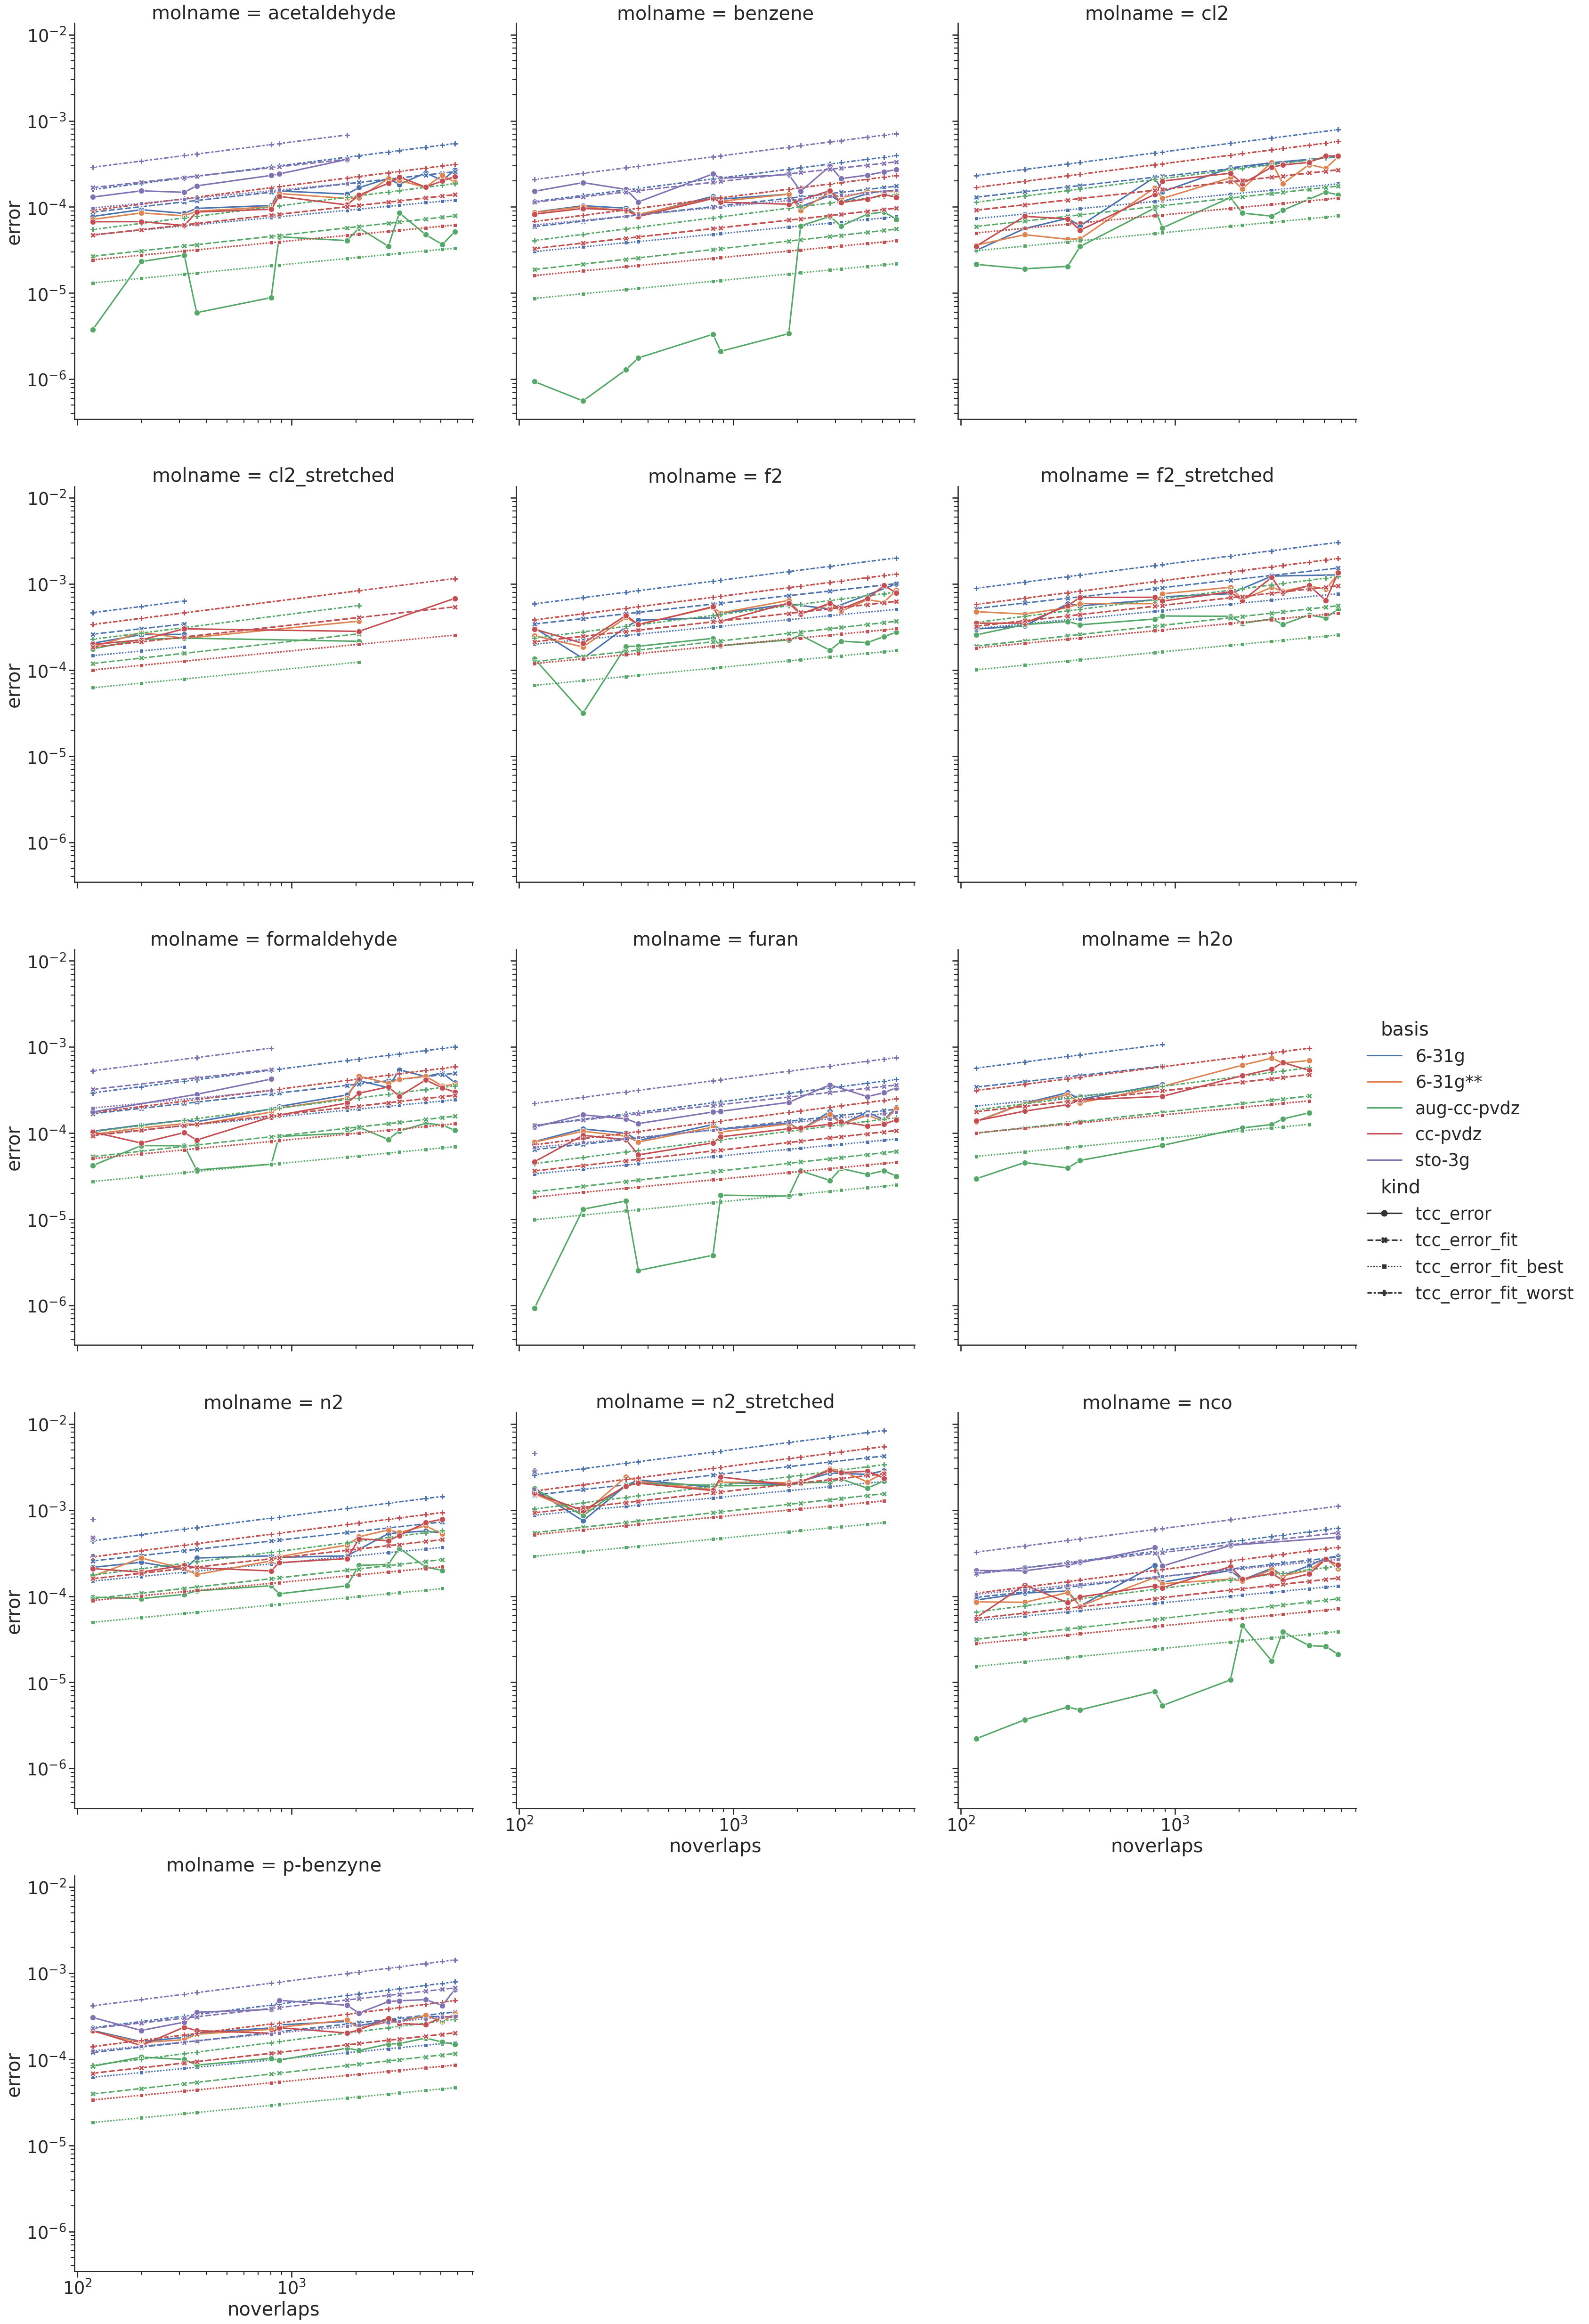

In [28]:
# display(merged_df)
sns.set_theme(context="talk", font_scale=1.6, style="ticks")
dfm = pd.melt(merged_df, value_name="error", var_name="kind", id_vars=['std', 'noverlaps', 'molname', 'basis', 'nact', 'nalpha', 'nbeta', 'nelec', 'nmo'],
              value_vars=[
                  'tcc_error',
                  'tcc_error_fit',
                  'tcc_error_fit_best', 'tcc_error_fit_worst'
                  ])
# display(dfm)
g = sns.relplot(
    # ax=ax,
    col_wrap=3,
    data=dfm,
    x="noverlaps",
    # x="nmo",
    y="error",
    col="molname",
    hue="basis",
    style="kind",
    markers=True,
    marker="o",
    # linewidth=2.5,
    # palette="flare",
    # errorbar=None,
    legend="full",
    # legend="brief",
    # hue_norm=mpl.colors.LogNorm()
    height=10,
    kind="line",
)
g.set(
    xscale="log",
    yscale="log",
)


In [18]:
grp = merged_df.groupby('noverlaps')
from pprint import pprint
blabla = {}
for ovlp, df_inner in grp:
    # print(ovlp, df_inner)
    if ovlp not in blabla:
        blabla[ovlp] = tuple(np.unique(x)[0] for x in (df_inner.nact, df_inner.nalpha, df_inner.nbeta))
pprint(blabla)

{118: (6, 3, 3),
 199: (8, 2, 2),
 316: (8, 3, 3),
 361: (8, 4, 4),
 805: (10, 6, 6),
 876: (10, 5, 5),
 1819: (12, 6, 6),
 2068: (16, 3, 3),
 2836: (14, 5, 5),
 3193: (16, 4, 4),
 4236: (16, 5, 5),
 5071: (16, 6, 6),
 5793: (16, 8, 8)}


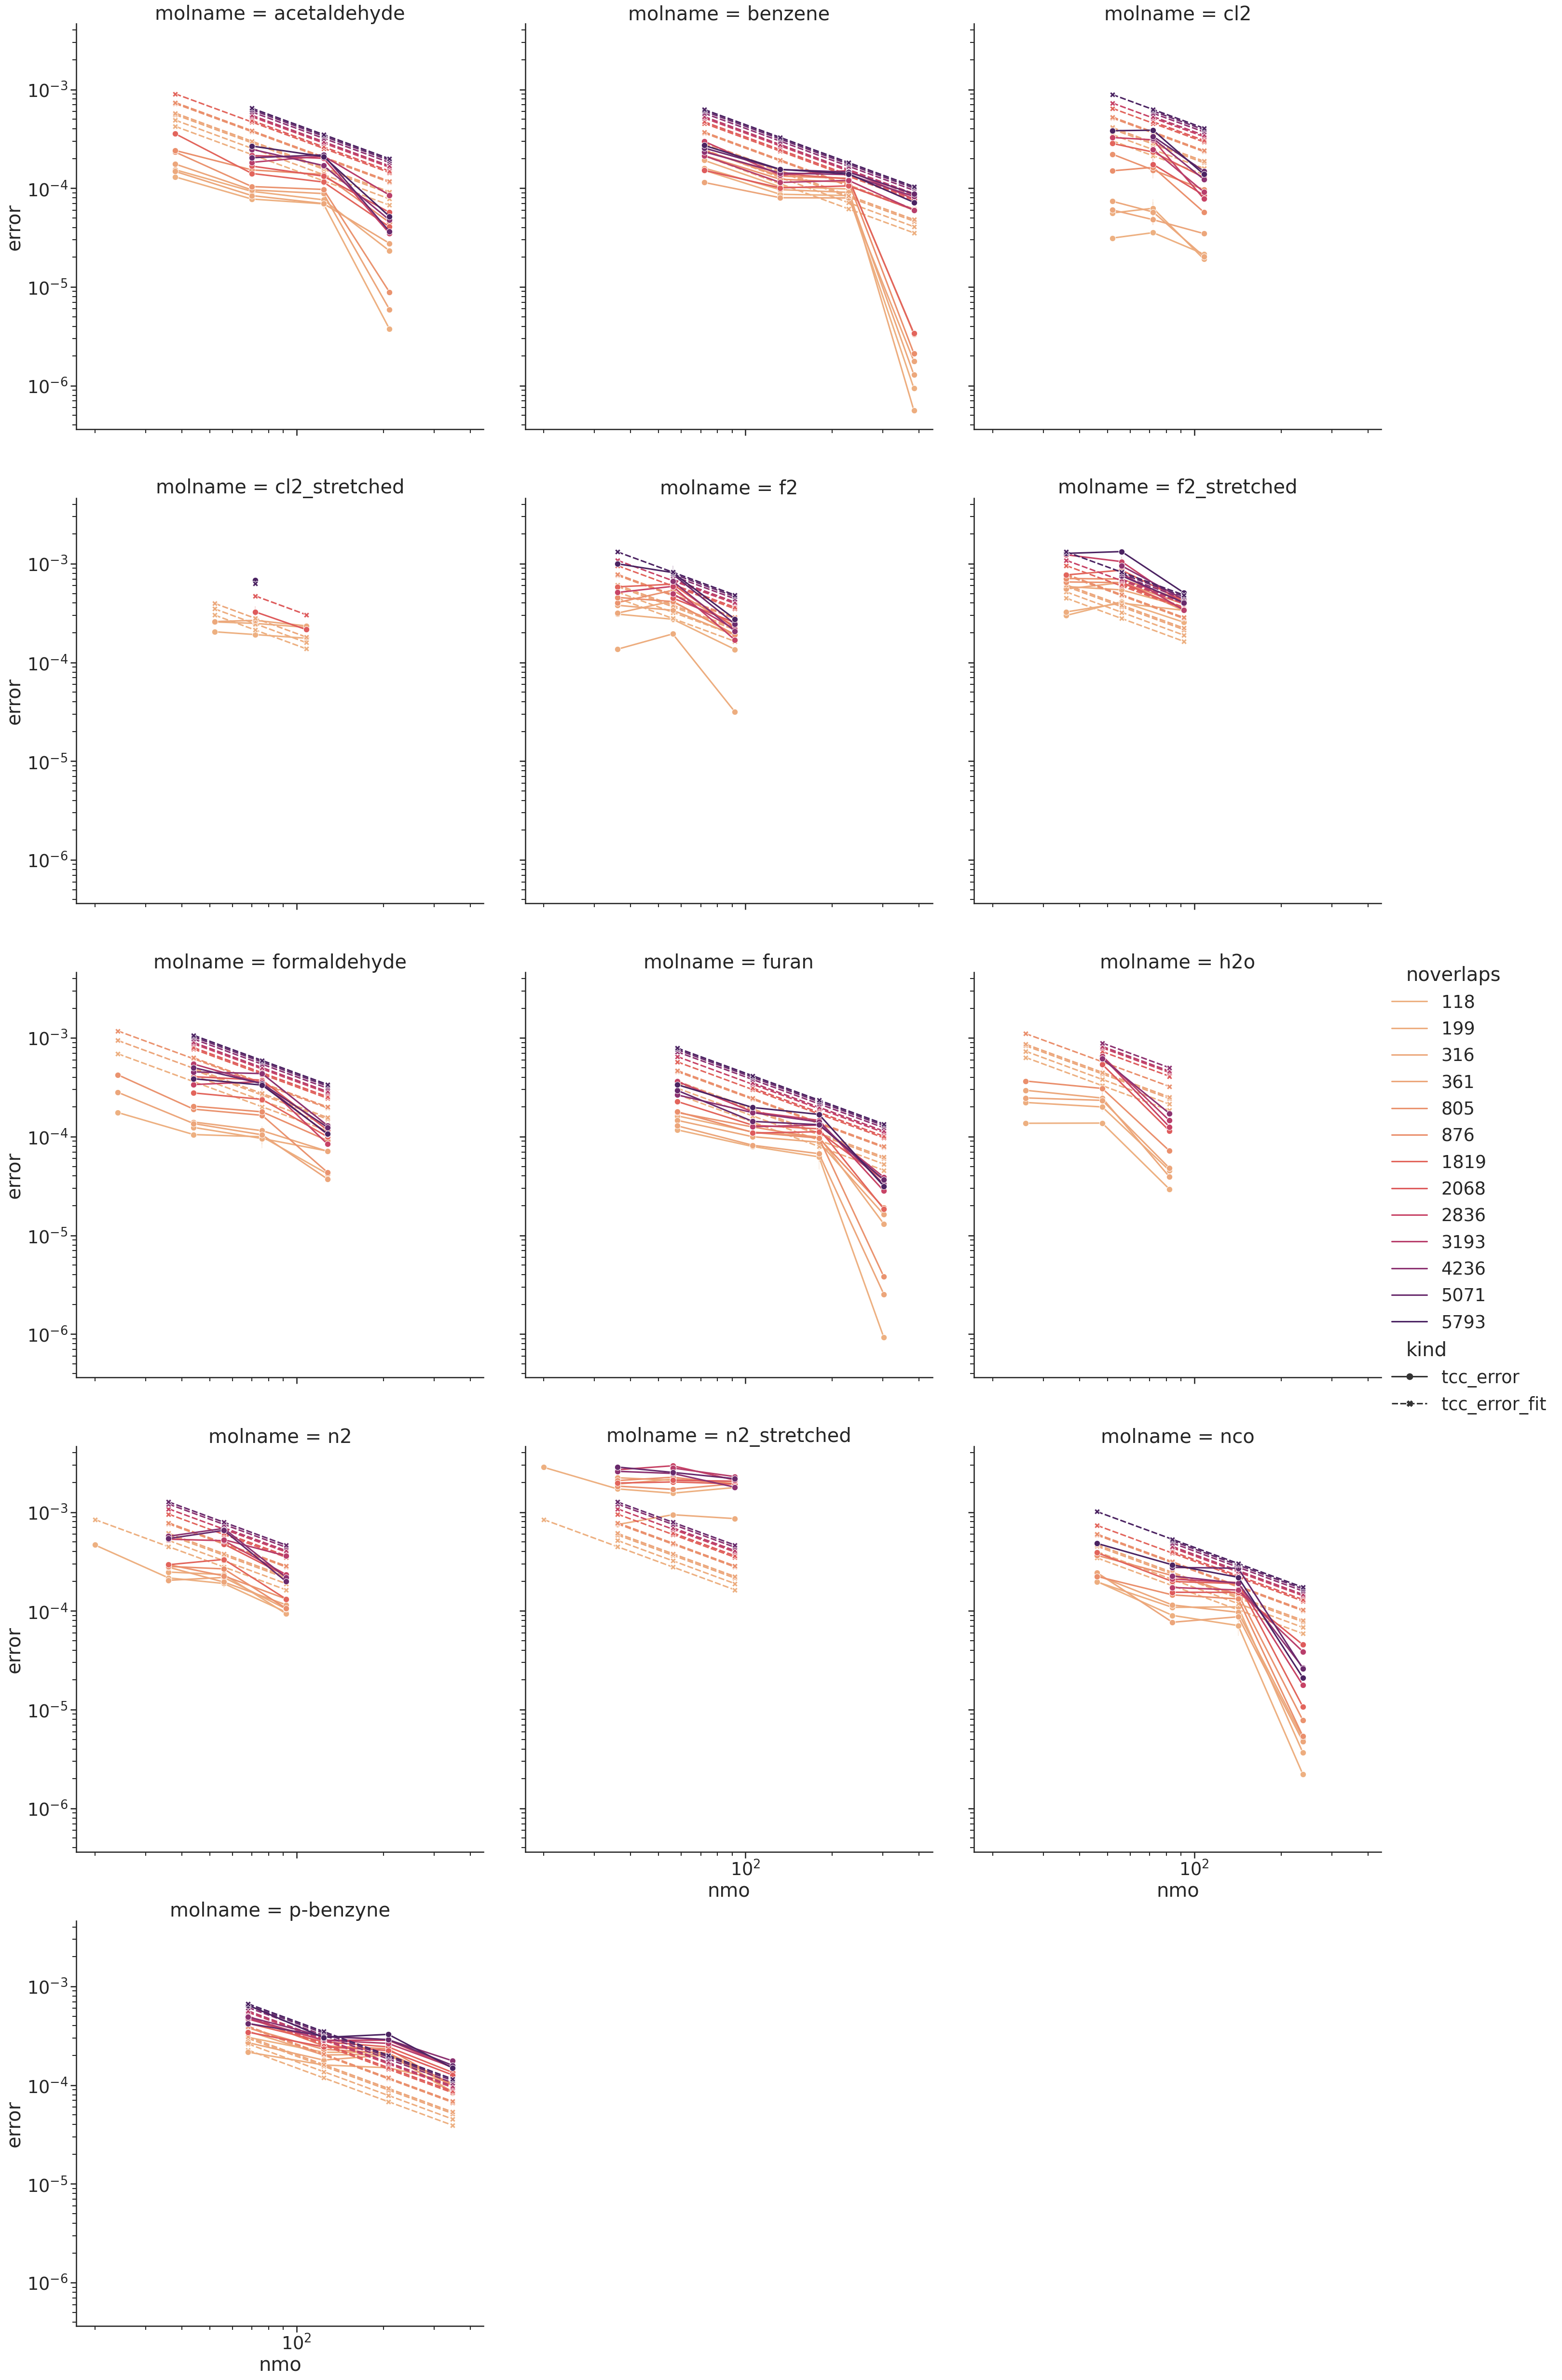

In [17]:
g = sns.relplot(
    # ax=ax,
    col_wrap=3,
    data=dfm,
    x="nmo",
    y="error",
    col="molname",
    hue="noverlaps",
    style="kind",
    markers=True,
    marker="o",
    # linewidth=2.5,
    palette="flare",
    # errorbar=None,
    legend="full",
    # legend="brief",
    # hue_norm=mpl.colors.LogNorm()
    height=10,
    kind="line",
)
g.set(
    xscale="log",
    yscale="log",
)